C:\Users\vikne\anaconda3\Lib\site-packages\keras\src\saving\saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'adam', because it has 22 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Epoch 1/12


C:\Users\vikne\anaconda3\Lib\site-packages\keras\src\backend\tensorflow\nn.py:602: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(
C:\Users\vikne\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


163/163 ━━━━━━━━━━━━━━━━━━━━ 90s 497ms/step - accuracy: 0.7188 - loss: 0.8663 - val_accuracy: 0.6875 - val_loss: 0.6845 - learning_rate: 0.0010
Epoch 2/12
163/163 ━━━━━━━━━━━━━━━━━━━━ 77s 464ms/step - accuracy: 0.7956 - loss: 0.4168 - val_accuracy: 0.8125 - val_loss: 0.7070 - learning_rate: 0.0010
Epoch 3/12
163/163 ━━━━━━━━━━━━━━━━━━━━ 82s 496ms/step - accuracy: 0.8386 - loss: 0.3411 - val_accuracy: 0.6875 - val_loss: 0.7917 - learning_rate: 0.0010
Epoch 4/12
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 487ms/step - accuracy: 0.8569 - loss: 0.3060
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
163/163 ━━━━━━━━━━━━━━━━━━━━ 81s 488ms/step - accuracy: 0.8569 - loss: 0.3060 - val_accuracy: 0.6875 - val_loss: 0.7222 - learning_rate: 0.0010
Epoch 5/12
163/163 ━━━━━━━━━━━━━━━━━━━━ 78s 472ms/step - accuracy: 0.8860 - loss: 0.2699 - val_accuracy: 0.8125 - val_loss: 0.5394 - learning_rate: 3.0000e-04
Epoch 6/12
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 437ms/step - accuracy: 0.8844 - loss

Model training complete and saved.


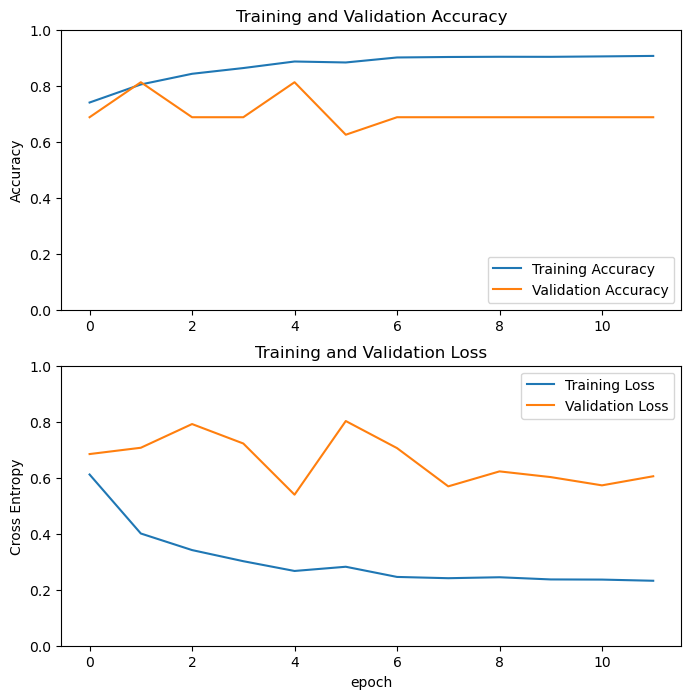

In [1]:
# Import necessary libraries
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import cv2
import os

# Define constants
labels = ['PNEUMONIA', 'NORMAL']
img_size = 150

# Function to get data from directory
def get_data(data_dir):
    data = [] 
    for label in labels: 
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                if img_arr is not None:  # Ensure the image is read correctly
                    resized_arr = cv2.resize(img_arr, (img_size, img_size))
                    data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data, dtype=object)

# Load data
train = get_data('../../chest_xray/train')
test = get_data('../../chest_xray/test')
val = get_data('../../chest_xray/val')

# Separate features and labels
x_train, y_train = [], []
x_val, y_val = [], []
x_test, y_test = [], []

for feature, label in train:
    x_train.append(feature)
    y_train.append(label)

for feature, label in test:
    x_test.append(feature)
    y_test.append(label)
    
for feature, label in val:
    x_val.append(feature)
    y_val.append(label)

# Normalize the data
x_train = np.array(x_train) / 255.0
x_val = np.array(x_val) / 255.0
x_test = np.array(x_test) / 255.0

# Reshape data for deep learning
x_train = x_train.reshape(-1, img_size, img_size, 1)
y_train = np.array(y_train)

x_val = x_val.reshape(-1, img_size, img_size, 1)
y_val = np.array(y_val)

x_test = x_test.reshape(-1, img_size, img_size, 1)
y_test = np.array(y_test)

# Load the saved model architecture from 03_model_building.ipynb
from tensorflow.keras.models import model_from_json

# Load model architecture
with open("cnn_model.json", "r") as json_file:
    json_saved_model = json_file.read()

# Load model
model = model_from_json(json_saved_model)

# Load initial weights
model.load_weights("cnn_initial_weights.weights.h5")

# Compile the model (again) if necessary
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# Data Augmentation
datagen = ImageDataGenerator(
    rotation_range=30,
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

datagen.fit(x_train)

# Learning rate reduction callback
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.3, 
                                            min_lr=0.000001)

# Train the model
history = model.fit(datagen.flow(x_train, y_train, batch_size=32), 
                    epochs=12, 
                    validation_data=(x_val, y_val), 
                    callbacks=[learning_rate_reduction])

# Save the trained model and weights
model.save("cnn_model_trained.h5")
model_json = model.to_json()
with open("cnn_model_trained.json", "w") as json_file:
    json_file.write(model_json)
model.save_weights("cnn_model_trained.weights.h5")

# Save training history
np.save('training_history.npy', history.history)

print("Model training complete and saved.")

# Plot training & validation accuracy values
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([0, 1.0])
plt.title('Training and Validation Accuracy')

# Plot training & validation loss values
plt.subplot(2, 1, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0, 1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()